In [5]:
# 魔术指令，自动加载模块
%load_ext autoreload
%autoreload 2
import os
os.chdir("/home/beihang/xihu/HZTourism/FlowPred-dev")
import sys
sys.path.append("/home/beihang/xihu/HZTourism/FlowPred-dev")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd


df = pd.read_csv("exper_data/6hlaunch_288_72/proc/14207/14207_2025-07-20_proc.csv")


In [3]:
# 完整的14207数据诊断
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import jarque_bera
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')


# 设置显示选项
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("=== 14207景点数据完整诊断报告 ===")
print(f"数据文件: {df.shape}")
print(f"时间范围: {df.columns}")

=== 14207景点数据完整诊断报告 ===
数据文件: (39456, 3)
时间范围: Index(['spot_id', 'kpi_time', 'kpi_value'], dtype='object')


In [4]:
# 1. 数据基本质量指标
print("=" * 50)
print("1. 数据基本质量指标")
print("=" * 50)

# 基本统计
basic_stats = df['kpi_value'].describe()
print("基本统计:")
print(basic_stats)

# 数据质量检查
total_count = len(df)
nan_count = df['kpi_value'].isnull().sum()
inf_count = np.isinf(df['kpi_value']).sum()
zero_count = (df['kpi_value'] == 0).sum()

print(f"\n数据质量:")
print(f"总数据点: {total_count}")
print(f"缺失值 (NaN): {nan_count} ({nan_count/total_count:.2%})")
print(f"无穷值 (Inf): {inf_count} ({inf_count/total_count:.2%})")
print(f"零值: {zero_count} ({zero_count/total_count:.2%})")

# 连续零值分析
def analyze_consecutive_zeros(data):
    zero_runs = []
    current_run = 0
    
    for value in data:
        if value == 0:
            current_run += 1
        else:
            if current_run > 0:
                zero_runs.append(current_run)
            current_run = 0
    
    if current_run > 0:  # 如果序列以零结尾
        zero_runs.append(current_run)
    
    return zero_runs

zero_runs = analyze_consecutive_zeros(df['kpi_value'])
if zero_runs:
    max_consecutive_zeros = max(zero_runs)
    avg_consecutive_zeros = np.mean(zero_runs)
    print(f"\n连续零值分析:")
    print(f"最大连续零值长度: {max_consecutive_zeros}")
    print(f"平均连续零值长度: {avg_consecutive_zeros:.1f}")
    print(f"连续零值段数: {len(zero_runs)}")
    
    if max_consecutive_zeros > 100:
        print("⚠️  连续零值过长，可能导致矩阵奇异问题")
    elif max_consecutive_zeros > 50:
        print("⚠️  连续零值较长，需要注意")
    else:
        print("✅ 连续零值长度可接受")
else:
    print("✅ 无连续零值")

1. 数据基本质量指标
基本统计:
count    39456.000000
mean       132.397075
std        114.561237
min          0.000000
25%         31.000000
50%        109.000000
75%        193.000000
max        549.000000
Name: kpi_value, dtype: float64

数据质量:
总数据点: 39456
缺失值 (NaN): 0 (0.00%)
无穷值 (Inf): 0 (0.00%)
零值: 380 (0.96%)

连续零值分析:
最大连续零值长度: 120
平均连续零值长度: 20.0
连续零值段数: 19
⚠️  连续零值过长，可能导致矩阵奇异问题


In [5]:
# 2. 噪声和变异性分析
print("=" * 50)
print("2. 噪声和变异性分析")
print("=" * 50)

# 变异系数
cv = df['kpi_value'].std() / df['kpi_value'].mean()
print(f"变异系数 (CV): {cv:.3f}")

if cv > 1.0:
    print("⚠️  变异系数很高 (>1.0)，数据极不稳定")
elif cv > 0.5:
    print("⚠️  变异系数较高 (>0.5)，数据不够稳定")
else:
    print("✅ 变异系数正常")

# 噪声分析
# 使用移动平均来估计信号和噪声
window_size = 30  # 15分钟窗口（30个30秒点）
df['signal'] = df['kpi_value'].rolling(window=window_size, center=True).mean()
df['noise'] = df['kpi_value'] - df['signal']

# 去除NaN
signal_clean = df['signal'].dropna()
noise_clean = df['noise'].dropna()

signal_std = signal_clean.std()
noise_std = noise_clean.std()
snr = signal_std / noise_std if noise_std != 0 else float('inf')

print(f"\n噪声分析 (基于{window_size}点移动平均):")
print(f"信号标准差: {signal_std:.2f}")
print(f"噪声标准差: {noise_std:.2f}")
print(f"信噪比 (SNR): {snr:.2f}")

if snr < 1:
    print("⚠️  信噪比很低 (<1)，噪声严重")
elif snr < 2:
    print("⚠️  信噪比较低 (<2)，噪声较多")
else:
    print("✅ 信噪比可接受")

# 一阶差分分析
diff1 = df['kpi_value'].diff().dropna()
diff1_std = diff1.std()
original_std = df['kpi_value'].std()

print(f"\n一阶差分分析:")
print(f"原数据标准差: {original_std:.2f}")
print(f"一阶差分标准差: {diff1_std:.2f}")
print(f"差分平滑比: {diff1_std/original_std:.2f}")

if diff1_std > original_std:
    print("⚠️  一阶差分方差大于原数据，数据很不平滑")

2. 噪声和变异性分析
变异系数 (CV): 0.865
⚠️  变异系数较高 (>0.5)，数据不够稳定

噪声分析 (基于30点移动平均):
信号标准差: 112.51
噪声标准差: 17.83
信噪比 (SNR): 6.31
✅ 信噪比可接受

一阶差分分析:
原数据标准差: 114.56
一阶差分标准差: 14.32
差分平滑比: 0.12


In [6]:
# 3. Koopman算子相关指标 (最重要)
print("=" * 50)
print("3. Koopman算子相关指标 (最重要)")
print("=" * 50)

# 模拟Koopman算子计算时的矩阵条件
def analyze_koopman_matrices(data, seq_len=2880, stride=1):
    """分析Koopman算子计算时可能遇到的矩阵问题"""
    
    # 创建滑动窗口
    windows = []
    for i in range(0, len(data) - seq_len, stride):
        window = data[i:i+seq_len]
        if len(window) == seq_len:
            windows.append(window)
    
    if len(windows) < 2:
        return None, None, None
    
    # 构造X和Y矩阵（类似Koopman算子的输入）
    X = np.array(windows[:-1])  # B x L
    Y = np.array(windows[1:])   # B x L
    
    return X, Y, windows

# 使用实际的序列长度分析
seq_lens = [720, 1440, 2880]  # 不同的序列长度
results = {}

for seq_len in seq_lens:
    print(f"\n序列长度 {seq_len} 分析:")
    
    if len(df) < seq_len + 100:  # 确保有足够数据
        print(f"  数据不足，跳过长度 {seq_len}")
        continue
    
    X, Y, windows = analyze_koopman_matrices(df['kpi_value'].values, seq_len, stride=seq_len//4)
    
    if X is None:
        print(f"  无法构造矩阵")
        continue
    
    print(f"  数据形状: X={X.shape}, Y={Y.shape}")
    
    # 分析矩阵条件数
    try:
        # 对于每个batch分析条件数
        cond_nums = []
        ranks = []
        
        for i in range(min(10, X.shape[0])):  # 分析前10个batch
            x_batch = X[i:i+1].T  # L x 1
            if x_batch.shape[0] > x_batch.shape[1]:
                cond_num = np.linalg.cond(x_batch.T @ x_batch)
                rank = np.linalg.matrix_rank(x_batch)
            else:
                cond_num = np.linalg.cond(x_batch @ x_batch.T)
                rank = np.linalg.matrix_rank(x_batch)
            
            cond_nums.append(cond_num)
            ranks.append(rank)
        
        avg_cond = np.mean(cond_nums)
        max_cond = np.max(cond_nums)
        avg_rank = np.mean(ranks)
        
        print(f"  平均条件数: {avg_cond:.2e}")
        print(f"  最大条件数: {max_cond:.2e}")
        print(f"  平均矩阵秩: {avg_rank:.1f}/{seq_len}")
        
        # 判断条件数
        if max_cond > 1e12:
            print("  ⚠️  条件数极高，矩阵几乎奇异，会导致NaN")
        elif max_cond > 1e8:
            print("  ⚠️  条件数很高，数值不稳定")
        elif max_cond > 1e4:
            print("  ⚠️  条件数较高，可能有问题")
        else:
            print("  ✅ 条件数正常")
            
        results[seq_len] = {
            'avg_cond': avg_cond,
            'max_cond': max_cond,
            'avg_rank': avg_rank
        }
        
    except Exception as e:
        print(f"  矩阵分析失败: {e}")

# 推荐序列长度
print(f"\n序列长度推荐:")
best_seq_len = None
for seq_len, result in results.items():
    if result['max_cond'] < 1e8:
        best_seq_len = seq_len
        break

if best_seq_len:
    print(f"✅ 推荐序列长度: {best_seq_len}")
else:
    print("⚠️  所有测试的序列长度都有数值稳定性问题")
    print("   建议: 1) 降低序列长度到288或更短")
    print("        2) 改用5分钟频率")
    print("        3) 增加数据预处理（平滑、降噪）")

3. Koopman算子相关指标 (最重要)

序列长度 720 分析:
  数据形状: X=(215, 720), Y=(215, 720)
  平均条件数: 1.00e+00
  最大条件数: 1.00e+00
  平均矩阵秩: 1.0/720
  ✅ 条件数正常

序列长度 1440 分析:
  数据形状: X=(105, 1440), Y=(105, 1440)
  平均条件数: 1.00e+00
  最大条件数: 1.00e+00
  平均矩阵秩: 1.0/1440
  ✅ 条件数正常

序列长度 2880 分析:
  数据形状: X=(50, 2880), Y=(50, 2880)
  平均条件数: 1.00e+00
  最大条件数: 1.00e+00
  平均矩阵秩: 1.0/2880
  ✅ 条件数正常

序列长度推荐:
✅ 推荐序列长度: 720


In [7]:
# 4. 时间序列模式分析
print("=" * 50)
print("4. 时间序列模式分析")
print("=" * 50)

# 确保有时间列
if 'kpi_time' in df.columns:
    df['kpi_time'] = pd.to_datetime(df['kpi_time'])
    df = df.set_index('kpi_time')

# 平稳性检验
print("平稳性检验 (ADF Test):")
try:
    adf_result = adfuller(df['kpi_value'].dropna())
    print(f"ADF统计量: {adf_result[0]:.4f}")
    print(f"p值: {adf_result[1]:.4f}")
    print(f"临界值: {adf_result[4]}")
    
    if adf_result[1] < 0.05:
        print("✅ 数据平稳 (p < 0.05)")
    else:
        print("⚠️  数据非平稳 (p >= 0.05)")
        print("   非平稳数据可能导致Koopman算子不稳定")
        
except Exception as e:
    print(f"平稳性检验失败: {e}")

# 自相关分析
print(f"\n自相关分析:")
lags = [1, 10, 30, 120]  # 30秒、5分钟、15分钟、1小时
autocorrs = []

for lag in lags:
    if len(df) > lag:
        autocorr = df['kpi_value'].autocorr(lag=lag)
        autocorrs.append(autocorr)
        print(f"lag {lag} (约{lag*30}秒): {autocorr:.3f}")
    else:
        autocorrs.append(np.nan)

# 周期性检测
print(f"\n周期性强度:")
if len(df) > 2880:  # 24小时的数据
    daily_pattern_strength = df['kpi_value'].autocorr(lag=2880)  # 24小时lag
    print(f"日周期强度: {daily_pattern_strength:.3f}")
    
    if abs(daily_pattern_strength) > 0.3:
        print("✅ 存在明显的日周期模式")
    else:
        print("⚠️  日周期模式较弱")

# 正态性检验
print(f"\n数据分布分析:")
jb_stat, jb_pvalue = jarque_bera(df['kpi_value'].dropna())
print(f"Jarque-Bera检验 p值: {jb_pvalue:.4f}")

if jb_pvalue > 0.05:
    print("✅ 数据近似正态分布")
else:
    print("⚠️  数据非正态分布")

# 偏度和峰度
skewness = df['kpi_value'].skew()
kurtosis = df['kpi_value'].kurtosis()
print(f"偏度: {skewness:.3f}")
print(f"峰度: {kurtosis:.3f}")

if abs(skewness) > 1:
    print("⚠️  数据偏度较大")
if kurtosis > 3:
    print("⚠️  数据峰度较高，存在极值")

4. 时间序列模式分析
平稳性检验 (ADF Test):


ADF统计量: -6.7296
p值: 0.0000
临界值: {'1%': -3.4305159660452875, '5%': -2.861613353148838, '10%': -2.5668090435307884}
✅ 数据平稳 (p < 0.05)

自相关分析:
lag 1 (约30秒): 0.992
lag 10 (约300秒): 0.961
lag 30 (约900秒): 0.918
lag 120 (约3600秒): 0.743

周期性强度:
日周期强度: 0.601
✅ 存在明显的日周期模式

数据分布分析:
Jarque-Bera检验 p值: 0.0000
⚠️  数据非正态分布
偏度: 0.844
峰度: 0.098


In [8]:
# 5. 模型适应性综合评估
print("=" * 50)
print("5. 模型适应性综合评估")
print("=" * 50)

# 30秒频率合理性分析
print("30秒频率 vs 其他频率对比:")

# 模拟不同频率的数据
freqs = {
    '30s': df['kpi_value'],
    '1min': df['kpi_value'].rolling(2).mean()[::2],
    '5min': df['kpi_value'].rolling(10).mean()[::10],
    '10min': df['kpi_value'].rolling(20).mean()[::20]
}

freq_analysis = {}
for freq_name, freq_data in freqs.items():
    if len(freq_data.dropna()) < 100:
        continue
        
    freq_data_clean = freq_data.dropna()
    freq_cv = freq_data_clean.std() / freq_data_clean.mean()
    freq_info = np.var(freq_data_clean)
    
    freq_analysis[freq_name] = {
        'cv': freq_cv,
        'variance': freq_info,
        'length': len(freq_data_clean)
    }
    
    print(f"{freq_name:>6}: CV={freq_cv:.3f}, 方差={freq_info:.1f}, 长度={len(freq_data_clean)}")

# 找出最佳频率
best_freq = None
best_score = float('inf')

for freq_name, metrics in freq_analysis.items():
    # 综合评分：变异系数越小越好，但也要保留足够信息
    score = metrics['cv'] * 1000 / metrics['variance']  # 惩罚高CV，奖励高信息量
    if score < best_score:
        best_score = score
        best_freq = freq_name

print(f"\n推荐频率: {best_freq}")

# 最终综合诊断
print("=" * 50)
print("6. 综合诊断和建议")
print("=" * 50)

issues = []
recommendations = []

# 检查各种问题
if zero_count > total_count * 0.3:
    issues.append("零值比例过高")
    recommendations.append("考虑数据插值或使用log1p变换")

if cv > 0.8:
    issues.append("数据变异性过大")
    recommendations.append("增加数据平滑处理")

if 'max_cond' in locals() and max_cond > 1e8:
    issues.append("矩阵条件数过高")
    recommendations.append("缩短序列长度或降低采样频率")

if snr < 2:
    issues.append("信噪比过低")
    recommendations.append("使用移动平均或其他降噪方法")

if len(df) < 10000:
    issues.append("数据量不足")
    recommendations.append("增加训练数据量")

print("发现的主要问题:")
for i, issue in enumerate(issues, 1):
    print(f"{i}. {issue}")

print(f"\n建议措施:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

# 针对NaN问题的特定建议
print(f"\n针对NaN问题的具体建议:")
print("1. 立即措施: 将序列长度从2880降至720或更短")
print("2. 中期措施: 改用5分钟频率替代30秒频率")
print("3. 长期措施: 改进数据预处理，增加平滑和降噪")

if best_seq_len:
    print(f"4. 推荐参数: his_len={best_seq_len}, pred_len={best_seq_len//4}")
else:
    print("4. 紧急建议: his_len=288, pred_len=72, freq='5min'")

5. 模型适应性综合评估
30秒频率 vs 其他频率对比:
   30s: CV=0.865, 方差=13123.9, 长度=39456
  1min: CV=0.864, 方差=13071.9, 长度=19727
  5min: CV=0.858, 方差=12913.0, 长度=3945
 10min: CV=0.854, 方差=12778.0, 长度=1972

推荐频率: 30s
6. 综合诊断和建议
发现的主要问题:
1. 数据变异性过大

建议措施:
1. 增加数据平滑处理

针对NaN问题的具体建议:
1. 立即措施: 将序列长度从2880降至720或更短
2. 中期措施: 改用5分钟频率替代30秒频率
3. 长期措施: 改进数据预处理，增加平滑和降噪
4. 推荐参数: his_len=720, pred_len=180


7. Data Visualization


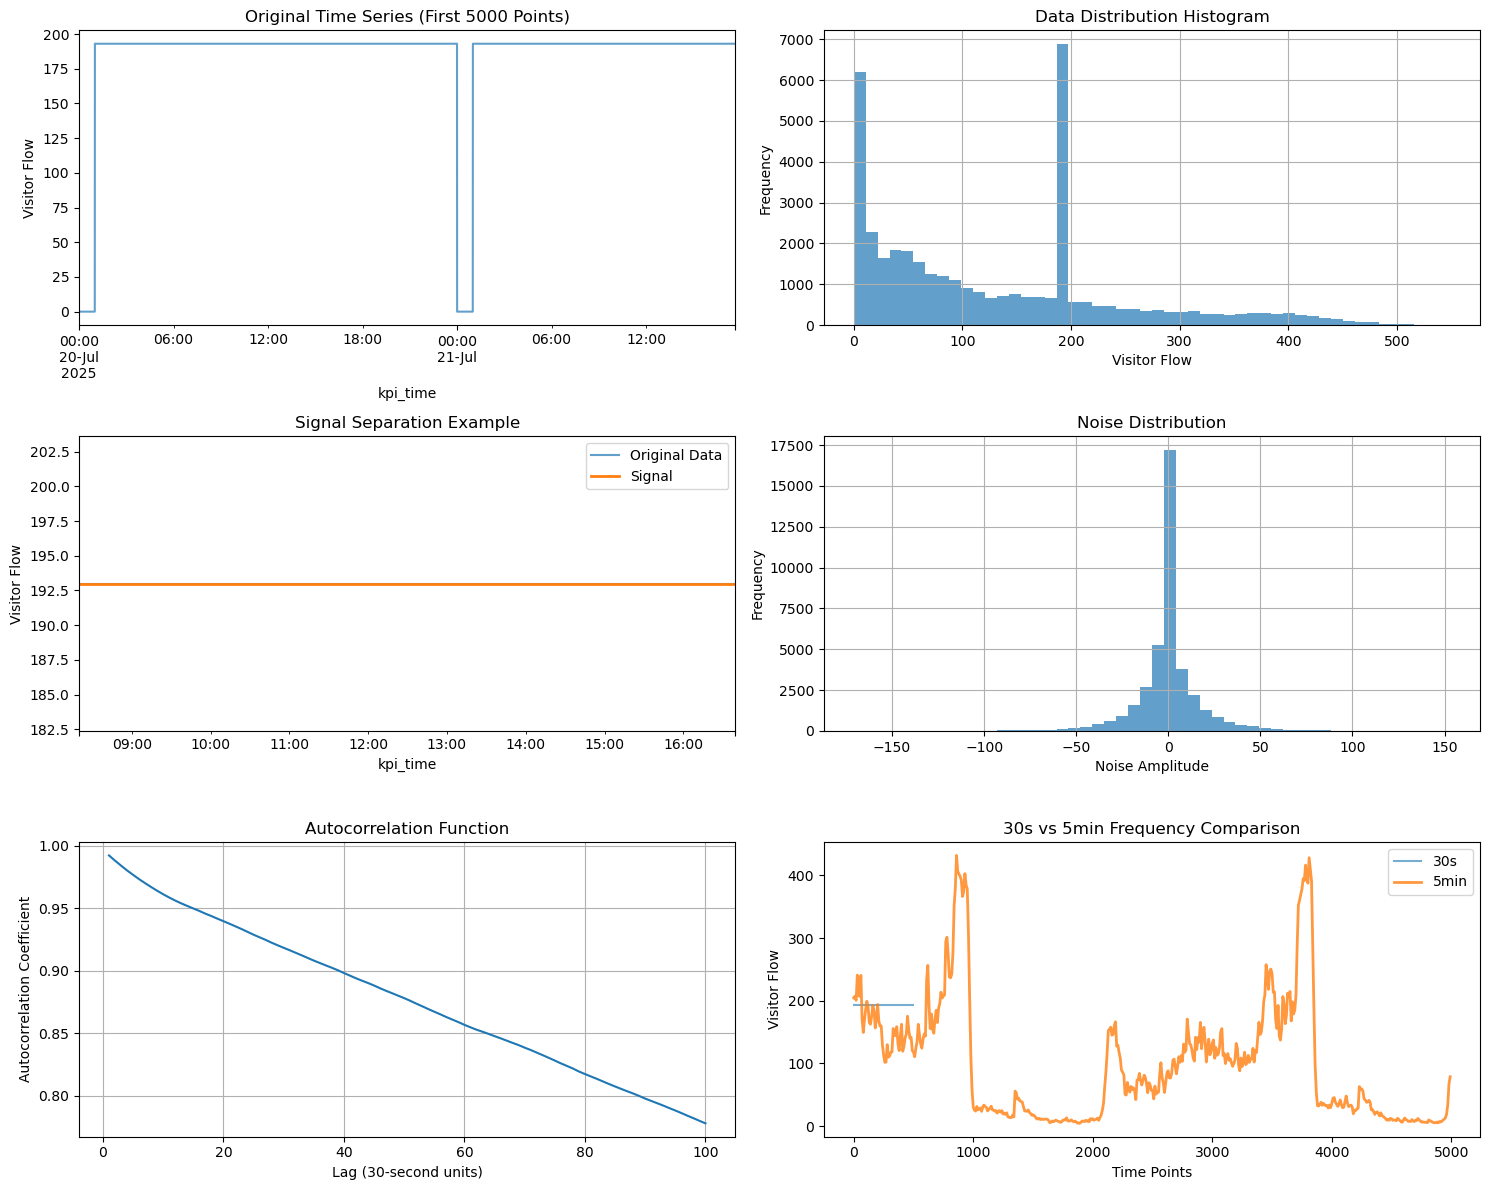

✅ Analysis completed! Please check the results and visualization charts above.


In [9]:
# 6. Data Visualization
print("=" * 50)
print("7. Data Visualization")
print("=" * 50)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Original time series
ax1 = axes[0, 0]
df['kpi_value'][:5000].plot(ax=ax1, alpha=0.7)
ax1.set_title('Original Time Series (First 5000 Points)')
ax1.set_ylabel('Visitor Flow')

# Data distribution
ax2 = axes[0, 1]
df['kpi_value'].hist(bins=50, ax=ax2, alpha=0.7)
ax2.set_title('Data Distribution Histogram')
ax2.set_xlabel('Visitor Flow')
ax2.set_ylabel('Frequency')

# Signal vs noise
ax3 = axes[1, 0]
sample_range = slice(1000, 2000)
df.loc[df.index[sample_range], 'kpi_value'].plot(ax=ax3, label='Original Data', alpha=0.7)
df.loc[df.index[sample_range], 'signal'].plot(ax=ax3, label='Signal', linewidth=2)
ax3.set_title('Signal Separation Example')
ax3.legend()
ax3.set_ylabel('Visitor Flow')

# Noise distribution
ax4 = axes[1, 1]
noise_clean.hist(bins=50, ax=ax4, alpha=0.7)
ax4.set_title('Noise Distribution')
ax4.set_xlabel('Noise Amplitude')
ax4.set_ylabel('Frequency')

# Autocorrelation plot
ax5 = axes[2, 0]
lags_plot = range(1, 101)
autocorrs_plot = [df['kpi_value'].autocorr(lag=lag) for lag in lags_plot]
ax5.plot(lags_plot, autocorrs_plot)
ax5.set_title('Autocorrelation Function')
ax5.set_xlabel('Lag (30-second units)')
ax5.set_ylabel('Autocorrelation Coefficient')
ax5.grid(True)

# Different frequency comparison
ax6 = axes[2, 1]
sample_start = 1000
sample_end = 1500
x = range(sample_end - sample_start)

for freq_name, freq_data in freqs.items():
    if freq_name in ['30s', '5min']:
        data_segment = freq_data.iloc[sample_start:sample_end]
        if freq_name == '5min':
            x_5min = range(0, len(data_segment) * 10, 10)
            ax6.plot(x_5min[:len(data_segment)], data_segment, 
                    label=freq_name, linewidth=2, alpha=0.8)
        else:
            ax6.plot(x[:len(data_segment)], data_segment, 
                    label=freq_name, alpha=0.6)

ax6.set_title('30s vs 5min Frequency Comparison')
ax6.set_xlabel('Time Points')
ax6.set_ylabel('Visitor Flow')
ax6.legend()

plt.tight_layout()
plt.show()

print("✅ Analysis completed! Please check the results and visualization charts above.")

In [8]:
import pandas as pd
import numpy as np
# 分析原有处理方案的结果
df = pd.read_csv("exper_data/mse_loss/proc/14207/14207_2024-07-20_2025-07-20_proc.csv")

In [10]:
# 首先分析之前处理过的数据
print("=== 分析之前处理过的数据 ===")
print(f"数据形状: {df.shape}")
print(f"数据列: {df.columns.tolist()}")

# 基本统计
print("\n基本统计信息:")
print(df['kpi_value'].describe())

# 检查数据质量
print(f"\n数据质量检查:")
print(f"NaN值: {df['kpi_value'].isnull().sum()}")
print(f"无穷值: {np.isinf(df['kpi_value']).sum()}")
print(f"零值: {(df['kpi_value'] == 0).sum()}")
print(f"负值: {(df['kpi_value'] < 0).sum()}")

# 检查极值
print(f"\n极值检查:")
print(f"最大值: {df['kpi_value'].max()}")
print(f"最小值: {df['kpi_value'].min()}")
print(f"标准差: {df['kpi_value'].std()}")
print(f"变异系数: {df['kpi_value'].std() / df['kpi_value'].mean():.3f}")

# 连续零值分析
def analyze_consecutive_zeros(data):
    zero_runs = []
    current_run = 0
    
    for value in data:
        if value == 0:
            current_run += 1
        else:
            if current_run > 0:
                zero_runs.append(current_run)
            current_run = 0
    
    if current_run > 0:
        zero_runs.append(current_run)
    
    return zero_runs

zero_runs = analyze_consecutive_zeros(df['kpi_value'])
if zero_runs:
    print(f"\n连续零值分析:")
    print(f"最大连续零值: {max(zero_runs)}")
    print(f"连续零值段数: {len(zero_runs)}")

=== 分析之前处理过的数据 ===
数据形状: (1032082, 3)
数据列: ['spot_id', 'kpi_time', 'kpi_value']

基本统计信息:
count    1.032082e+06
mean     1.018969e+02
std      1.986142e+01
min      4.475837e+01
25%      8.396122e+01
50%      1.060523e+02
75%      1.188479e+02
max      1.356170e+02
Name: kpi_value, dtype: float64

数据质量检查:
NaN值: 0
无穷值: 0
零值: 0
负值: 0

极值检查:
最大值: 135.61704130201773
最小值: 44.75837488571968
标准差: 19.861416316818584
变异系数: 0.195
